In [ ]:
## EEG signal classification into wake and drowsy using CNN network

## adding upsampling through SMOTE & a different network
## *** the random sampling is done across all examples, instead of by ID ***

## POSSIBLE PROBLEMS & SOLUTIONS:
# 1. overfitting (see the plots - how bad ?) 
# no. of training examples: 83076 (train set) = Train on 74768 samples, validate on 8308 samples
# no. of trainable parameters: 4,793,957
# => reduce the no. of epochs
#    upsample data, 
#    reduce parameters/ change network, 
#    use dropout (in last-but-one layer)
##   WHERE IS THE LEARNING RATE BEING SPECIFIED ?

# 2. issue with parameter values: softmax vs sigmoid,  dense = 1 or 2,  binary or categorical cross-entropy

# 3. conversion of CNN output (float) to category (0,1) - why not done by the model?


## how to do train test split keeping class distribution similar
## use stratified_sampling (keep class ratios similar in train test sets) instead of random sampling
# https://datascience.stackexchange.com/questions/32818/train-test-split-of-unbalanced-dataset-classification
## class_weight = balanced (giving more weightage to penalties for the smaller class)
# https://stackoverflow.com/questions/30972029/how-does-the-class-weight-parameter-in-scikit-learn-work



##  INFERENCE: recall is low (0.65) for sleep state (class 1)  ##

#(array([0.92174321, 0.89073806]),
# array([0.98116972, 0.64823591]),
# array([0.95052854, 0.75038098]),
# array([8019, 1899]))


In [1]:
import pandas as pd
import numpy as np
import os
import pickle
from scipy import stats
import itertools
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split


import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D


/home/intern_eyecare/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/intern_eyecare/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
file_location=r'/home/intern_eyecare/Desktop/EEG/raw_data' #C:\Users\BOL1KOR\Desktop\BCI Project\Pickle_Files\Pickle_files_eeg'
os.chdir(r'/home/intern_eyecare/Desktop/EEG/raw_data') #C:\Users\BOL1KOR\Desktop\BCI Project\Pickle_Files\Pickle_files_eeg')


In [3]:
dfull = pickle.load(open('raw_EEG_all_patients.pkl', 'rb'))  #raw_EEG_all_patients.pkl

In [4]:
dfull.head(3)

,0,1,2,3,4,5,6,7,8,9,...,2994,2995,2996,2997,2998,2999,pID,day,epoch,class_label
0,9.041758,-6.624176,2.756044,-1.305495,15.134066,-11.942857,-5.850549,3.626374,-3.819780,-24.320879,...,9.041758,2.369231,1.885714,9.041758,7.301099,16.294505,404,2,s1e1,wake
1,9.428571,13.296703,11.169231,14.167033,6.334066,10.589011,6.817582,10.202198,12.716484,7.107692,...,-28.382418,-14.747253,-23.547253,-23.257143,-13.683516,-7.494505,404,2,s1e2,wake
2,-0.048352,-7.687912,-14.360440,-17.745055,-21.903297,-16.874725,-16.874725,-12.523077,-12.909890,-15.520879,...,1.305495,3.723077,-6.720879,-4.303297,-6.527473,-4.109890,404,2,s1e3,wake


In [5]:
### Convert from 3-class to 2-class ####
dfull['class2'] = dfull['class_label']
dfull['class2'] = [0 if x == 'wake' else 1 for x in dfull['class2']]

In [6]:
## convert selected columns to categories 
## DO NOT CONVERT 'class2' from numeric to category - this probably gives error in grid search
dfull[['class_label']] = dfull[['class_label']].astype('str')        # ,'class2'
#dfull[['class_label']] = dfull[['class_label']].astype('category')   # ,'class2'

In [7]:
dfull.groupby('class_label').size()

class_label
sleep_stage_1     2804
sleep_stage_2    17799
wake             72391
dtype: int64

In [8]:
## drop column '2999' with NAN values instead of dropping the rows (which will reduce data)
dfull = dfull.drop([2999],1)
dfull.head(1)

,0,1,2,3,4,5,6,7,8,9,...,2994,2995,2996,2997,2998,pID,day,epoch,class_label,class2
0,9.041758,-6.624176,2.756044,-1.305495,15.134066,-11.942857,-5.850549,3.626374,-3.81978,-24.320879,...,9.041758,2.369231,1.885714,9.041758,7.301099,404,2,s1e1,wake,0


In [9]:
## create stratified sets for training & testing
X =  dfull.drop(['pID','day','epoch','class_label','class2'], 1) # dfull[['delta','theta','alpha','beta','gamma']]
y =  dfull['class2'] 

In [10]:
X.head(1)

,0,1,2,3,4,5,6,7,8,9,...,2989,2990,2991,2992,2993,2994,2995,2996,2997,2998
0,9.041758,-6.624176,2.756044,-1.305495,15.134066,-11.942857,-5.850549,3.626374,-3.81978,-24.320879,...,40.18022,40.47033,39.6,57.49011,-0.048352,9.041758,2.369231,1.885714,9.041758,7.301099


In [11]:
y = dfull[['class2']]
y.head(2)

,class2
0,0
1,0


In [12]:
X_train1, X_test, y_train1, y_test = train_test_split(X, y, test_size=0.2, random_state=0)  #stratify=y) #stratify=True
# use 'stratify=True' for consistent class distribution between training and test sets


In [13]:
# to test if split is stratified
y_tr = pd.DataFrame(y_train1)
y_ts = pd.DataFrame(y_test)
print('')
print(y_tr.groupby('class2').size())
print('')
print(y_ts.groupby('class2').size())


class2
0    57921
1    16474
dtype: int64

class2
0    14470
1     4129
dtype: int64


In [ ]:
#### segregate data into train:test set by pat id, then balance the data
'''
### all patient data ##
#ID = dfull['pID']
#ID = pd.DataFrame(dfull['pID'].unique())
ID = dfull['pID'].unique()
#ID.dtype  ## => dtype('O')

#Test = dfull[ (dfull.pID == '402') & (dfull.day == '2') ]
#Train = dfull[~( (dfull.pID == '402') & (dfull.day == '2') )]

np.random.seed(456)
msk = np.random.rand(len(ID)) < 0.8

trainIDs = pd.DataFrame()
testIDs = pd.DataFrame()
#trainIDs['pID'] = ID[msk]
#testIDs['pID'] = ID[~msk]
#trainIDs.reset_index(inplace=True)
#testIDs.reset_index(inplace=True)

Train = dfull.loc[dfull['pID'].isin(ID[msk])] #pd.DataFrame(getData(trainIDs['pID'],dfull), columns = dfull.columns)
Test = dfull.loc[dfull['pID'].isin(ID[~msk])] #pd.DataFrame(getData(testIDs['pID'],dfull), columns = dfull.columns)
'''

In [ ]:
'''
print(Train.shape)
print(Test.shape)

## also, check the distribution of class 0 & 1 in the train & test sets
print('Train distribution')
print(Train.groupby('class2').size())
print('')
print('Test distribution')
print(Test.groupby('class2').size())
'''

In [ ]:
'''
X_train1 = Train.drop(['pID','day','epoch','class_label','class2'], 1).reset_index()
X_test = Test.drop(['pID','day','epoch','class_label','class2'], 1).reset_index()
y_train1 = Train['class2'].reset_index()
y_test = Test['class2'].reset_index()

X_train1 = X_train1.drop(['index'], 1)
X_test = X_test.drop(['index'],1)
y_train1 = y_train1.drop(['index'],1)
y_test = y_test.drop(['index'],1)

print(X_train1.head(1))
#print(X_test.head(1))
print('')
print(y_train1.head(1))
#print(y_test.head(1))
'''

In [ ]:
'''print(y_train1.groupby('class2').size())'''

In [14]:
#'''
## upsample training set
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train1, y_train1)
#print('Resampled dataset shape %s' % Counter(y_train))
#print(y_train.groupby('class2').size())
#'''

/home/intern_eyecare/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [15]:
check_upsample = pd.DataFrame(y_train)
check_upsample.columns = ['class2']
check_upsample.head(2)
#print(y_train.groupby('class2').size())

,class2
0,0
1,0


In [ ]:
'''check_upsample.columns = ['class2']
check_upsample.head(2)'''

In [ ]:
#print(check_upsample.groupby('class2').size())

In [ ]:
'''X_tr = pd.DataFrame(X_train)
check_upsample = pd.concat([check_upsample,X_tr], axis=1)
check_upsample.head(1)'''

In [ ]:
'''## write to file
import pickle
pickle.dump(check_upsample, open('/home/intern_eyecare/Desktop/EEG/upsampled_data_SMOTE_new_network.pkl','wb'))'''

In [16]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
# http://benalexkeen.com/feature-scaling-with-scikit-learn/
# standardscaler: suitable for normally distributed data
# minMaxScaler: (x-min)/(max - min)

## normalize the data  : can also use other scalers like StandardScaler()
scaler = StandardScaler()  #MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
#X_train_scaled.shape

In [17]:
## re-shaping tha data for input to conv net
# https://stackoverflow.com/questions/43235531/convolutional-neural-network-conv1d-input-shape
nrows, ncols = X_train_scaled.shape
X_train_array =  X_train_scaled.reshape(nrows, ncols, 1)
print(X_train_array)

[[[-0.22869415]
  [-0.40791384]
  [-0.19095984]
  ...
  [ 0.48564487]
  [-1.52944621]
  [-0.65025702]]

 [[ 0.03666098]
  [ 0.44510713]
  [ 0.24056382]
  ...
  [ 0.22678173]
  [ 0.31768694]
  [ 0.14571514]]

 [[ 0.58851357]
  [ 0.36501047]
  [ 0.07924776]
  ...
  [ 0.67556547]
  [-0.1352035 ]
  [-0.37873132]]

 ...

 [[-0.73175087]
  [-0.67575179]
  [-0.68469178]
  ...
  [ 0.08524671]
  [ 0.2250233 ]
  [ 0.08706873]]

 [[ 0.03900818]
  [-0.25009133]
  [ 0.06146285]
  ...
  [ 0.24803128]
  [ 0.37451014]
  [ 0.20848668]]

 [[ 0.86282562]
  [ 0.69838218]
  [ 0.66352441]
  ...
  [ 0.69432585]
  [ 0.79875336]
  [ 0.43160111]]]


In [ ]:
#### model building ####

In [18]:
from datetime import datetime
datetime.now().strftime('%Y-%m-%d %H:%M:%S')

'2019-01-21 14:26:13'

In [ ]:
'''# define model: 1 conv layer, 1 fully-connected layer, 1 output layer
model = Sequential()  ## to initialize NN

model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(ncols, 1))) 
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(50, activation='relu'))

model.add(Dense(1, activation='sigmoid'))  # this is the output layer for binary classification
print(model.summary())

# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])'''

In [19]:
# define model: 5 conv layer, 2 fully-connected layer, 1 output layer
model = Sequential()  ## to initialize NN

model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(ncols, 1))) 
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=32, kernel_size=3, activation='relu')) 
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=32, kernel_size=3, activation='relu')) 
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=32, kernel_size=3, activation='relu')) 
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=32, kernel_size=3, activation='relu')) 
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(32, activation='relu'))

model.add(Dense(16, activation='relu'))

model.add(Dense(1, activation='sigmoid'))  # this is the output layer for binary classification
print(model.summary())

# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 2997, 32)          128       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1498, 32)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1496, 32)          3104      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 748, 32)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 746, 32)           3104      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 373, 32)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 371, 32)           3104      
__________

In [20]:
history = model.fit(X_train_array, y_train, epochs=50, batch_size=64, validation_split=0.1, verbose=1)

## steps to plot train & validation accuracy & loss
#https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy
#history = model.fit(x_test, y_test, nb_epoch=10, validation_split=0.2, shuffle=True)

Train on 104257 samples, validate on 11585 samples
Epoch 1/50
104257/104257 [==============================] - 57s 543us/step - loss: 0.0839 - acc: 0.9674 - val_loss: 0.0502 - val_acc: 0.9849
Epoch 2/50
104257/104257 [==============================] - 55s 530us/step - loss: 0.0427 - acc: 0.9846 - val_loss: 0.0128 - val_acc: 0.9969
Epoch 3/50
104257/104257 [==============================] - 55s 527us/step - loss: 0.0360 - acc: 0.9871 - val_loss: 0.0083 - val_acc: 0.9992
Epoch 4/50
104257/104257 [==============================] - 55s 527us/step - loss: 0.0317 - acc: 0.9886 - val_loss: 0.0137 - val_acc: 0.9967
Epoch 5/50
104257/104257 [==============================] - 55s 527us/step - loss: 0.0266 - acc: 0.9907 - val_loss: 0.0263 - val_acc: 0.9916
Epoch 6/50
104257/104257 [==============================] - 55s 525us/step - loss: 0.0222 - acc: 0.9926 - val_loss: 0.0132 - val_acc: 0.9970
Epoch 7/50
104257/104257 [==============================] - 54s 521us/step - loss: 0.0182 - acc: 0.9938

In [21]:
datetime.now().strftime('%Y-%m-%d %H:%M:%S')

'2019-01-21 15:11:30'

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


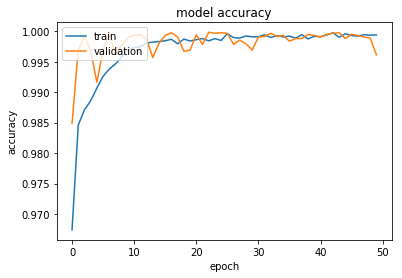

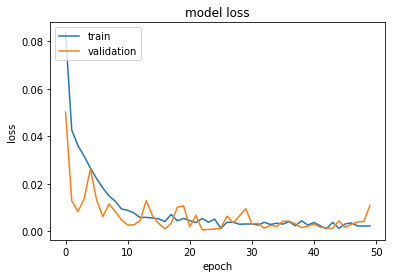

In [22]:
#https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
#import pickle
#pickle.dump(model, open('/home/intern_eyecare/Desktop/EEG/cnn_model.pkl','wb'))
#model.save('/home/intern_eyecare/Desktop/EEG/new_cnn_model_smote.pkl')

In [23]:
## predict on test data - check metrics
#y_pred = model_svc.predict(X_test_scaled)

nrows2, ncols2 = X_test_scaled.shape
X_test_array =  X_test_scaled.reshape(nrows2, ncols2, 1)
y_pred = model.predict(X_test_array)

In [24]:
print(y_test.head(2))
print('')
print(y_test.tail(3))

       class2
73543       0
44150       0

       class2
23004       0
80793       0
6836        1


In [ ]:
#y_test.dtypes()

In [25]:
y_pred

array([[0.0000000e+00],
       [0.0000000e+00],
       [2.2760862e-28],
       ...,
       [5.2720893e-36],
       [0.0000000e+00],
       [1.0000000e+00]], dtype=float32)

In [26]:
# convert array to dataframe

y_pred2 = pd.DataFrame(y_pred)
print(y_pred2.head(2))
print('')
print(y_pred2.tail(2))

     0
0  0.0
1  0.0

         0
18597  0.0
18598  1.0


In [27]:
y_pred3 = round(y_pred2)
y_pred3
print(y_pred3.head(2))
print('')
print(y_pred3.tail(2))

     0
0  0.0
1  0.0

         0
18597  0.0
18598  1.0


In [28]:
y_pred3[0].unique()

array([0., 1.])

In [29]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [30]:
## Confusion matrix
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support

class_names = [0,1] #['wake','sleep_stage_1','sleep_stage_2']  # wake, SS1, SS2  ; # '0','1','2'

cnf_matrix = confusion_matrix(y_test, y_pred3)
np.set_printoptions(precision=2)
print(cnf_matrix)  #(confusion_matrix(y_test, y_pred3))

[[14335   135]
 [  206  3923]]


Normalized confusion matrix
[[0.99 0.01]
 [0.05 0.95]]


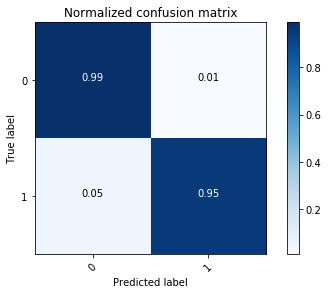

In [31]:
# Plot normalized confusion matrix : normalisation shows nan for class'0' no signal has class=0 as true label
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()


In [32]:
## join the test set predictions & actual values into a dataframe
res = y_pred3
res.columns = ['pred']
res.head(2)

,pred
0,0.0
1,0.0


In [33]:
res = pd.concat([res,y_test], axis=1)
res.head(2)

,pred,class2
0,0.0,NaN
1,0.0,NaN


In [34]:
precision_recall_fscore_support(y_test,y_pred3)

# layout of results
# precision: class 0, class 1   ==> [0: wake; 1: sleep/drowsy/fatigue]
# recall: class 0, class 1
# f1 score: class 0, class 1
# support: class 0, class 1

## INFERENCE: recall is low for sleep state

(array([0.99, 0.97]),
 array([0.99, 0.95]),
 array([0.99, 0.96]),
 array([14470,  4129]))

In [ ]:
#print(classification_report(y_test, y_pred3, target_names=class_names))
#print(classification_report(res['class2'], res['pred'], target_names=class_names))